# EVI - Tumbarumba


A timeseries of __EVI__ change at the tumbarumba study site from __Nov 2019 - May 2021__ using __Sentinal 2 Imagery__

This study measures the presence of vegetation through `enhanced vegetation index (EVI)`.
The index that will be used is dictated by the `veg_proxy` parameter that was set in the "Analysis parameters" section.

The Enhanced Vegetation Index requires the `red`, `nir` and `blue` bands.
The formula is

$$
\begin{aligned}
\text{EVI} & = \frac{2.5 \times (\text{NIR} - \text{Red})}{(\text{NIR} + 6 \times \text{Red} - 7.5 \times \text{Blue} + 1)} \\
\end{aligned}
$$


Both indices are available through the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [dea_bandindices.py](../Scripts/dea_bandindices.py).
Here, we use `collection='ga_s2_1'` since we're working with Sentinel-2 data.

### Packages

In [5]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import os

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.temporal import xr_phenology


In [6]:
dc = datacube.Datacube(app='Vegetation_phenology') ## Connects to the datacube

### Input Analysis Paramaters

In [7]:
# Set the vegetation proxy to use
veg_proxy = 'EVI'

# Define area of interest
lat = -35.655958
lon = 148.151751
lon_buffer = 0.005
lat_buffer = 0.005

# Set the range of dates for the analysis
#time_range = ('2017-01', '2019-06')
time_range = ('2016-01', '2021-05')

In [8]:
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

### Selected location for NDVI Analysis

In [9]:
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)
display_map(x=lon_range, y=lat_range)

### Cloud masking requirements
Aim is to get imagery that are a min of 75% cloud free

In [10]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir_1'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:3577',
    'group_by': 'solar_day'
}

# Load available data from Sentinel 2
ds = load_ard(
    dc=dc,
    products=['s2a_ard_granule', 's2b_ard_granule'],
    min_gooddata=0.75,
    **query,
)

print(ds)

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 271 out of 634 time steps with at least 75.0% good quality pixels
Applying pixel quality/cloud mask
Loading 271 time steps
<xarray.Dataset>
Dimensions:      (time: 271, y: 62, x: 52)
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01T00:09:15.704000 ... 2021-05...
  * y            (y) float64 -3.987e+06 -3.987e+06 ... -3.988e+06 -3.988e+06
  * x            (x) float64 1.457e+06 1.457e+06 ... 1.458e+06 1.458e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) float32 572.0 541.0 540.0 ... 365.0 432.0 331.0
    nbart_green  (time, y, x) float32 564.0 553.0 528.0 ... 244.0 309.0 236.0
    nbart_blue   (time, y, x) float32 496.0 466.0 482.0 ... 104.0 178.0 101.0
    nbart_nir_1  (time, y, x) float32 2.23e+03 2.014e+03 ... 1.488e+03 1.637e+03
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref


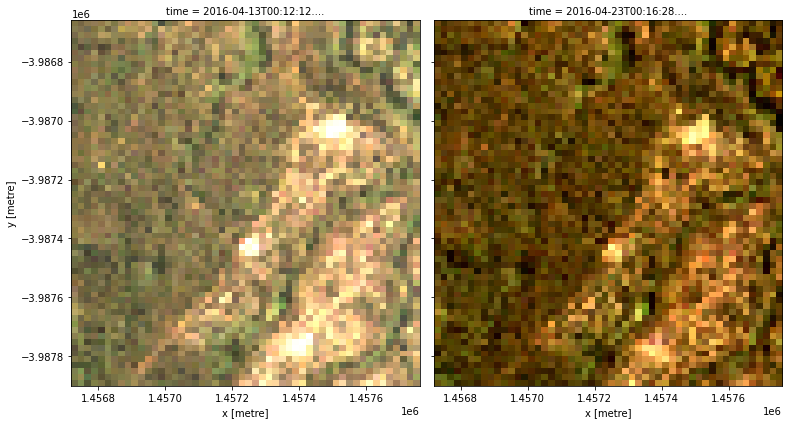

In [11]:
# print a selection of the imagery to check for consistency
timestep = ds.sel(time = '2016-04')
#print(timestep)
rgb(timestep, col = 'time', col_wrap=3) # Modify index dep on images selected above

### Compute EVI over the timeseries

In [12]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds, index=veg_proxy, collection='ga_s2_1')

# Save the EVI to the dask cluster
ds[veg_proxy] = ds[veg_proxy]

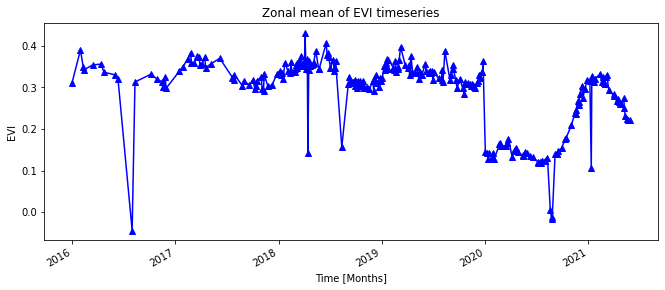

In [13]:
ds[veg_proxy].mean(['x', 'y']).plot.line('b-^', figsize=(11, 4))
plt.title('Zonal mean of EVI timeseries')
plt.xlabel('Time [Months]');

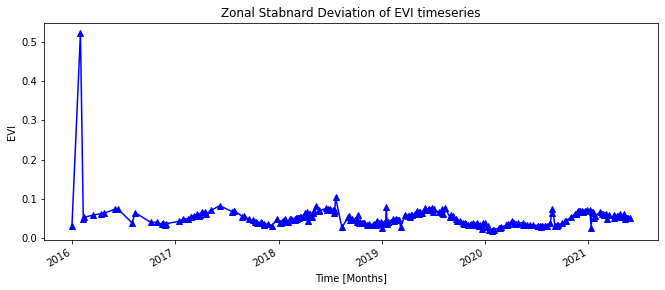

In [14]:
ds[veg_proxy].std(['x', 'y']).plot.line('b-^', figsize=(11, 4))
plt.title('Zonal Stabnard Deviation of EVI timeseries')
plt.xlabel('Time [Months]');

__Smooth the timeseries to remove incoonsistencies__

In [15]:
resample_period='2W'
window=4

veg_smooth=ds[veg_proxy].resample(time=resample_period).median().rolling(time=window, min_periods=1).mean()

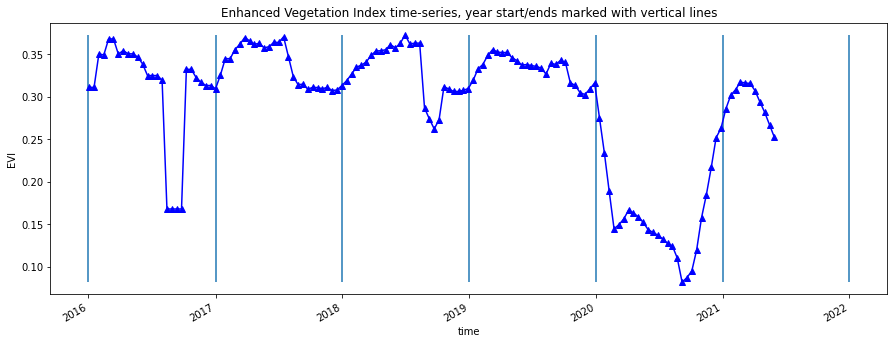

In [16]:
veg_smooth_1D = veg_smooth.mean(['x', 'y'])
veg_smooth_1D.plot.line('b-^', figsize=(15,5))
_max=veg_smooth_1D.max()
_min=veg_smooth_1D.min()
plt.vlines(np.datetime64('2016-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2017-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2018-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2019-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2020-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2021-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2022-01-01'), ymin=_min, ymax=_max)
plt.title('Enhanced Vegetation Index time-series, year start/ends marked with vertical lines')
plt.ylabel('EVI');

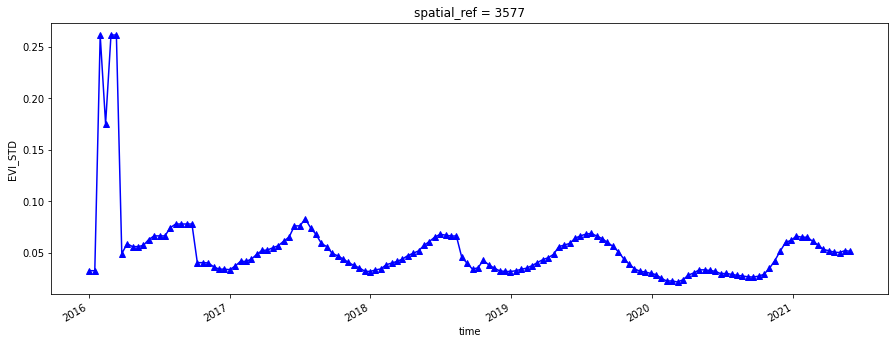

In [19]:
veg_smooth_1D_STD = veg_smooth.std(['x', 'y'])
veg_smooth_1D_STD.plot.line('b-^', figsize=(15,5))
_max=veg_smooth_1D_STD.max()
_min=veg_smooth_1D_STD.min()
plt.ylabel('EVI_STD');

## Result outputs

Modify time for export

In [20]:
veg_smooth_time = veg_smooth.time
arr = np.array(veg_smooth_time, dtype='datetime64[s]')

Exporting EVI

In [ ]:
df = pd.DataFrame(veg_smooth_1D, columns = ['EVI'])

In [ ]:
df['time'] = arr

In [ ]:
from numpy import savetxt
df.to_csv('EVI_smoothed_mean.csv')

In [24]:
df2 = pd.DataFrame(veg_smooth_1D_STD, columns = ['EVI_STD'])

In [25]:
df2['time'] = arr

In [26]:
from numpy import savetxt
df2.to_csv('EVI_smoothed_std.csv')

### Analysis

The EVI variance is as expected following the bushfire in Dec 2019. It is interesting that that recovery 
seems is not as immediate compared to NDVI. It can also be seen that there is a lare dip in the NDVI signal in late August of 2020. the reason for this dip must therefore be investigated further by running the NDVI Analysis over a smaller time period and examining the imagery to find any reasons for the discrepency.